In [12]:
import boto3
import pandas as pd

In [53]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg, coalesce, to_date

spark = SparkSession \
        .builder \
        .config("spark.jars", "/path/to/hadoop-aws-2.7.5.jar")\
        .getOrCreate()

In [19]:
df = pd.read_csv('United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')

In [33]:
cleaned = df[df['submission_date'] != '']
cleaned = cleaned[cleaned['state'] != '']
cleaned = cleaned[cleaned['tot_cases'] != None]

In [84]:
model_data = cleaned[['submission_date', 'tot_cases']]
# model_data = model_data.withColumn('tot_cases', col('tot_cases').cast('int'))
# model_data = model_data.withColumn('submission_date', to_date($"submission_date", "MM/dd/yyyy")
model_data

,submission_date,tot_cases
0,01/01/2021,1300528
1,04/30/2020,7145
2,02/26/2020,0
3,03/05/2020,2
4,05/04/2020,1224
...,...,...
27835,09/05/2020,162362
27836,10/19/2020,72968
27837,02/26/2020,0
27838,02/29/2020,0


In [107]:
model_data=model_data.groupby('submission_date')['tot_cases'].sum()
model_data = model_data.reset_index()

In [199]:
from datetime import datetime
dates = model_data['submission_date']
cases = model_data['tot_cases'].to_frame()
dates = pd.to_datetime(dates).to_frame()


In [196]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

degree=2
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
# polyreg.fit(dates,cases)
coefs = np.polyfit(dates.values.flatten(),cases.values.flatten(),degree)

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('float64')

In [186]:
import numpy as np
# dates_seq = np.linspace(dates.min(),dates.max(),300).reshape(-1,1)

start = pd.Timestamp("2020-01-22")
end = pd.Timestamp("2021-04-29")
t = np.linspace(start.value, end.value, 100)
dates_seq = pd.to_datetime(t).to_frame()

NameError: name 'coefs' is not defined

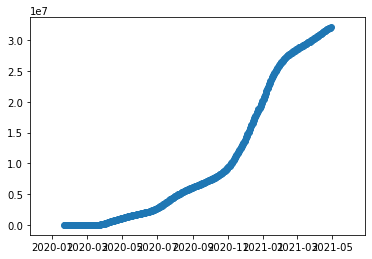

In [188]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(dates,cases)
# predict=polyreg.predict(dates_seq)
plt.plot(dates_seq, np.polyval(coefs, dates_seq), color="black")
plt.title("Polynomial regression with degree "+str(degree))
plt.show()

In [164]:
dates

,submission_date
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05
...,...
459,2020-12-27
460,2020-12-28
461,2020-12-29
462,2020-12-30


In [115]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

sdf = spark.createDataFrame(model_data)
sdf = sdf.withColumn("tot_cases", sdf["tot_cases"].cast(IntegerType()))

# list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
# df_with_vectors = sdf.select(
#     sdf["tot_cases"], 
#     list_to_vector_udf(sdf["submission_date"]).alias("submission_date")
# )

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler().setInputCols(['tot_cases']).setOutputCol('features')

transformed = assembler.transform(sdf)

train, test = transformed.randomSplit([0.7, 0.3])

In [116]:
from pyspark.ml.regression import LinearRegression
algo = LinearRegression(featuresCol="tot_cases", labelCol="medv")
model = algo.fit(train)


IllegalArgumentException: 'requirement failed: Column tot_cases must be of type struct<type:tinyint,size:int,indices:array<int>,values:array<double>> but was actually int.'